In [1]:
import pandas as pd
import os
import pickle
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from keras.datasets import cifar10
import random
from sklearn.metrics import silhouette_score, pairwise_distances
from validclust import dunn
from keras import regularizers

In [2]:
def preprocess(image_array):
    # converting colored images to gray scale
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    # Reshaping array to a single row with 1024 columns
    gray_reshaped = gray.reshape(1, 1024)
    # Scaling the features to values between zero and 1
    scaled = gray_reshaped / (255)
    return gray_reshaped

In [3]:
def preprocess_encoder(image_array):
    # converting colored images to gray scale
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    gray = gray/(255)
    return gray

In [4]:
def calculate_distance(inp_point, cluster_centroids):
    # calculating euclidean distance between the data point and cluster centroid.
    distances = [np.linalg.norm(inp_point - ctr) for ctr in cluster_centroids]

    cluster_no = distances.index(min(distances))

    return cluster_no

In [5]:
def recentre_centroids(cluster, data):
    # Taking the cluster number and data points as input
    # grouping together the data points with same cluster number
    unique_clusters = list(set(cluster))
    clustered_data_dict = {}
    # for all the unique clusters getting the data points belonging to that clusters
    for unq_num in unique_clusters: 
        same_cluster = []
        for num, point in zip(cluster, data):
            if unq_num == num:
                same_cluster.append(point)
        clustered_data_dict[unq_num] = np.array(same_cluster)
    # updating centroids as mean values of data points present in that cluster
    new_centroids = [ np.mean(value, axis = 0) for key, value in clustered_data_dict.items() ]
    return new_centroids, clustered_data_dict

In [6]:
def clustering(data, k, patience):
    # chossing k number of centroids randomly.
    cluster_centroids = []
    terminate = False
    patience_count = 0
    cluster_old = []
    random.seed(99)
    for i in range(k):
        cluster_centroids.append(random.choice(data))
    # calculating distances and assigning clusters
    iter_no = 1
    # The stop condition is if the cluster formed are same 
    # for patience number of times
    while terminate == False and patience_count < patience:
        if iter_no != 1:
            cluster_centroids, clustered_data_dict = recentre_centroids(cluster, data)
        cluster = [ calculate_distance(point, cluster_centroids) for point in data ]
        if cluster == cluster_old:
            patience_count += 1
#             print("patience reached", patience_count)
            if patience_count >= patience:
                terminate = True
        else:
            patience_count = 0
            terminate = False
        cluster_old = cluster
        iter_no += 1
#         print(" no of iterations : ", iter_no)
    return cluster, iter_no, clustered_data_dict

###  loading cifar10 data set

In [7]:
# load dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [8]:
print("shape of train ", X_train.shape)
print("shape of test", X_test.shape)

shape of train  (50000, 32, 32, 3)
shape of test (10000, 32, 32, 3)


### Part 1Using only test data for clustering

In [9]:
processed_X_test = np.array([ preprocess(img_array) for img_array in X_test ])
processed_X_test = processed_X_test.reshape(10000, 1024)
print(" shape of processed data : ", processed_X_test.shape)

 shape of processed data :  (10000, 1024)


In [10]:
import tqdm
dist = pairwise_distances(processed_X_test)
res = []
for n_clust in tqdm.tqdm(range(2, 12)):
    k = n_clust
    clusters_nos, iter_no, clustered_data_dict = clustering(processed_X_test, k, patience = 5)
    silhouette_avg = silhouette_score(processed_X_test, clusters_nos)
    dunn_index = dunn(dist, np.array(clusters_nos))
    print("For n_clusters =", k,"The average silhouette_score is :", silhouette_avg)
    print("dunns index is ", dunn_index)
    res.append([k, silhouette_avg, dunn_index] )

 10%|████▍                                       | 1/10 [00:04<00:37,  4.14s/it]

For n_clusters = 2 The average silhouette_score is : 0.17953866855626427
dunns index is  0.0919845985373622


 20%|████████▊                                   | 2/10 [00:08<00:32,  4.11s/it]

For n_clusters = 3 The average silhouette_score is : 0.11590471626887923
dunns index is  0.09005725342476706


 30%|█████████████▏                              | 3/10 [00:14<00:35,  5.08s/it]

For n_clusters = 4 The average silhouette_score is : 0.10320309347694681
dunns index is  0.08368556326723489


 40%|█████████████████▌                          | 4/10 [00:23<00:38,  6.48s/it]

For n_clusters = 5 The average silhouette_score is : 0.08747868928225702
dunns index is  0.08249664087520184


 50%|██████████████████████                      | 5/10 [00:37<00:46,  9.30s/it]

For n_clusters = 6 The average silhouette_score is : 0.07902653793812217
dunns index is  0.09142460937653932


 60%|██████████████████████████▍                 | 6/10 [00:48<00:38,  9.75s/it]

For n_clusters = 7 The average silhouette_score is : 0.07561892205073495
dunns index is  0.08310120111043925


 70%|██████████████████████████████▊             | 7/10 [01:05<00:36, 12.29s/it]

For n_clusters = 8 The average silhouette_score is : 0.06647005100891981
dunns index is  0.09773129466140822


 80%|███████████████████████████████████▏        | 8/10 [01:39<00:38, 19.04s/it]

For n_clusters = 9 The average silhouette_score is : 0.06468473843763464
dunns index is  0.08665430985693591


 90%|███████████████████████████████████████▌    | 9/10 [02:19<00:25, 25.64s/it]

For n_clusters = 10 The average silhouette_score is : 0.05402163199264537
dunns index is  0.08993630211024856


100%|███████████████████████████████████████████| 10/10 [02:52<00:00, 17.30s/it]

For n_clusters = 11 The average silhouette_score is : 0.054782964733661274
dunns index is  0.09143259681851422


### For 10 clusters

In [11]:
k = 10
clusters_nos, iter_no, clustered_data_dict = clustering(processed_X_test, k, patience = 5)
silhouette_avg = silhouette_score(processed_X_test, clusters_nos)
dunn_index = dunn(dist, np.array(clusters_nos))
print("For n_clusters =", k,"The average silhouette_score is :", silhouette_avg)
print("dunns index is ", dunn_index)

For n_clusters = 10 The average silhouette_score is : 0.05402163199264537
dunns index is  0.08993630211024856


## Part2 - Auto encoders

###### We are supposed to use training data from cifar

In [12]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Input, UpSampling2D
from keras import initializers, Sequential
from tensorflow.keras.models import Model

### Pre processing cifar train data

In [13]:
processed_X_train = np.array([ preprocess_encoder(img_array) for img_array in X_train ])
print(" shape of processed data : ", processed_X_train.shape)

 shape of processed data :  (50000, 32, 32)


### Defining an encoder model
The encoder part takes the input images and pass them through series of convolution and max pooling layers to produce the image in lower dimension with important features 

In [14]:
input_dimension = (processed_X_train.shape[1], processed_X_train.shape[2], 1)
inp_layer = Input(shape=(input_dimension))
encoder = Conv2D(filters = 3, kernel_size = (3, 3), padding = 'same',strides = (1,1), activation = 'relu',  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                 bias_initializer=initializers.Zeros, activity_regularizer=regularizers.l1(10e-9) )(inp_layer)
encoder = MaxPooling2D(pool_size = (2,2), padding = 'same')(encoder)
encoder = Conv2D(filters = 1, kernel_size = (3, 3), padding = 'same',strides = (1,1), activation = 'relu',  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                 bias_initializer=initializers.Zeros, activity_regularizer=regularizers.l1(10e-9))(encoder)
middle_layer = MaxPooling2D(pool_size = (2,2), padding = 'same')(encoder)

Metal device set to: Apple M1


2021-11-14 16:03:45.653517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-14 16:03:45.653897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Defining a decoder
Decoder accepts the ouput from encoders final layer, then the layers are stacked in reverse order as of encoder, to reconstruct the input. The final layer has a the dimension equal to the input_dimension.

In [15]:
decoder = Conv2D(filters = 1, kernel_size = (3, 3), padding = 'same',strides = (1,1), activation = 'relu',  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                 bias_initializer=initializers.Zeros, activity_regularizer=regularizers.l1(10e-9))(middle_layer)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(filters = 3, kernel_size = (3, 3), padding = 'same',strides = (1,1), activation = 'relu',  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                 bias_initializer=initializers.Zeros, activity_regularizer=regularizers.l1(10e-9) )(decoder)
decoder = UpSampling2D((2,2))(decoder)
output_layer =  Conv2D(filters = 1, kernel_size = (3, 3), padding = 'same',strides = (1,1), activation = 'relu',  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                 bias_initializer=initializers.Zeros, activity_regularizer=regularizers.l1(10e-9) )(decoder)

### Defining Auto encoder
Here the input layer and the decoder output are stacked together, to train the weights of both encoder and decoder such that the weights encode the image in smaller dimension.

In [16]:
model = Model(inputs=inp_layer, outputs=output_layer)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1)         28        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 1)         0     

In [18]:
history = model.fit(processed_X_train, processed_X_train, epochs=10, batch_size=32, verbose=2)

2021-11-14 16:04:43.173816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-14 16:04:43.177377: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-14 16:04:43.353798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
1563/1563 - 16s - loss: 0.0298
Epoch 2/10
1563/1563 - 16s - loss: 0.0144
Epoch 3/10
1563/1563 - 16s - loss: 0.0141
Epoch 4/10
1563/1563 - 16s - loss: 0.0138
Epoch 5/10
1563/1563 - 16s - loss: 0.0134
Epoch 6/10
1563/1563 - 16s - loss: 0.0133
Epoch 7/10
1563/1563 - 16s - loss: 0.0133
Epoch 8/10
1563/1563 - 16s - loss: 0.0133
Epoch 9/10
1563/1563 - 16s - loss: 0.0133
Epoch 10/10
1563/1563 - 16s - loss: 0.0133


### Using encoder to predict on train images

In [20]:
encoder = Model(inputs=inp_layer, outputs=middle_layer)

In [21]:
encoder_features = encoder.predict(processed_X_train)

2021-11-14 16:08:38.255045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


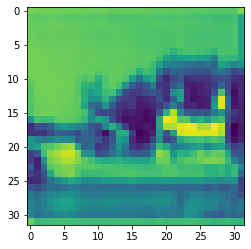

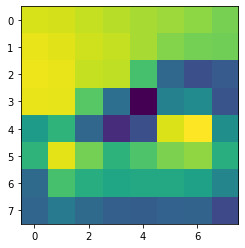

In [30]:
plt.imshow(processed_X_train[111])
plt.show()
plt.imshow(encoder_features[111])
plt.show()

In [24]:
flat_encoded = encoder_features.reshape(50000, -1)

### Running clustering on encoded features

In [25]:
k = 10
clusters_nos, iter_no, clustered_data_dict = clustering(flat_encoded, k, patience = 5)
silhouette_avg = silhouette_score(flat_encoded, clusters_nos)
print("For n_clusters =", k,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 10 The average silhouette_score is : 0.10401671


In [26]:
dist = pairwise_distances(flat_encoded)
dunn_index = dunn(dist, np.array(clusters_nos))
print("dunns index is ", dunn_index)

dunns index is  0.020386063
